In [184]:
import uproot
import ROOT
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import forestplot as fp
import mplhep as hep
import matplotlib._color_data as mcd
import matplotlib.colors as mcolors



# Load style sheet
plt.style.use(hep.style.CMS)
signal = uproot.open(
    "../TTbarSemileptonic_cbOnly_pruned_optimized_MuonSelection.root")["Events"]
background = uproot.open(
    "../TTbarSemileptonic_Nocb_optimized_MuonSelection.root")["Events"]

def get(key,numpy=True,library="pd"):
    arr=signal.arrays(key,library=library)[key]
    if numpy==True:
        return arr.to_numpy()
    else:
        return arr 

## Kinematic reconstruction of the neutrino

In [14]:
def neutrino_pz(lept_pt, lept_eta, lept_phi, MET_pt, MET_phi):
    Mw = 80.385
    El2 = lept_pt**2*np.cosh(lept_eta)**2
    Pt_scalar_product = MET_pt*lept_pt*np.cos(MET_phi-lept_phi)
    a = lept_pt**2
    b = -lept_pt*np.sinh(lept_eta)*(Mw**2+2*Pt_scalar_product)
    c = (-(Mw**2+2*Pt_scalar_product)**2+4*El2*(MET_pt**2))/4
    delta = b**2-4*a*c
    mask=delta<0
    delta[mask] = 0
    res0=((-b-np.sqrt(delta))/(2*a))
    res1=((-b+np.sqrt(delta))/(2*a))
    res=np.array([res0,res1])
    argmin = np.argmin([np.abs(res0), np.abs(res1)], axis=0)
    argmax = np.argmax([np.abs(res0), np.abs(res1)], axis=0)
    res[0]=np.array([res[elem, idx] for idx, elem in enumerate(argmin)])
    res[1]=np.array([res[elem, idx] for idx, elem in enumerate(argmax)])
    res=list(res)
    res.append(~mask)
    return res


def Wmass(lept_pt, lept_eta, lept_phi, MET_pt, MET_phi,nu_pz,lept_mass=0.105):
    Wmass_array=[]
    for i in range(len(nu_pz)):
        mu_4V = ROOT.Math.PtEtaPhiMVector(lept_pt[i], lept_eta[i], lept_phi[i], lept_mass)
        nu_4V = ROOT.Math.PtEtaPhiMVector(MET_pt[i], np.arcsinh(
            nu_pz[i]/MET_pt[i]), MET_phi[i], 0)
        Wmass_array.append((mu_4V+nu_4V).M())
    return np.array(Wmass_array)


In [3]:
nu_pz = neutrino_pz(get("Muon_pt[:,0]"), get("Muon_eta[:,0]"), get(
    "Muon_phi[:,0]"), get("MET_pt"), get("MET_phi"))

nu_pz_good_low = nu_pz[0][nu_pz[2]]
nu_pz_good_high = nu_pz[1][nu_pz[2]]
nu_pz_bad=nu_pz[0][~nu_pz[2]]

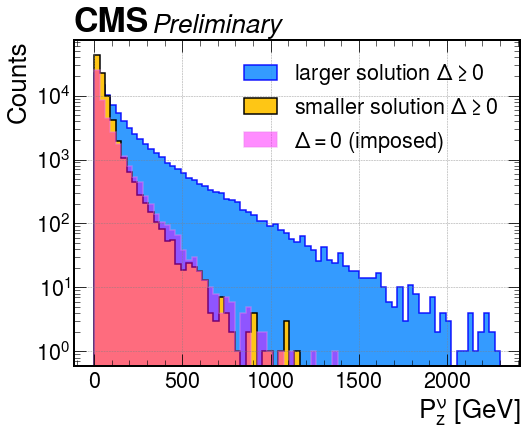

In [4]:
# plt.xkcd()
plt.figure(figsize=(8, 6))
plt.style.use(hep.style.CMS)
plt.hist(np.abs(nu_pz_good_high), bins=75, alpha=0.9,
         label=r"larger solution $\Delta \geq 0  $", range=(0, 2300), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=1.5)
plt.hist(np.abs(nu_pz_good_low), bins=75, alpha=1,
         label=r"smaller solution $\Delta \geq 0$", range=(0, 2300), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=1.5, edgecolor="black")
plt.hist(np.abs(nu_pz_bad), bins=75, alpha=0.45,
         label=r"$\Delta=0 $ (imposed)", range=(0, 2300), color="fuchsia", edgecolor='violet', histtype="stepfilled", linewidth=1.5)
plt.legend()
plt.xlabel(r"$P_z^{\nu}$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


In [15]:
mu_pt = get("Muon_pt[:,0]")
mu_eta = get("Muon_eta[:,0]")
mu_phi = get("Muon_phi[:,0]")
met_pt = get("MET_pt")
met_phi = get("MET_phi")
mu_pt_good=mu_pt[nu_pz[2]]
mu_eta_good=mu_eta[nu_pz[2]]
mu_phi_good=mu_phi[nu_pz[2]]
met_pt_good=met_pt[nu_pz[2]]
met_phi_good=met_phi[nu_pz[2]]
mu_pt_bad=mu_pt[~nu_pz[2]]
mu_eta_bad=mu_eta[~nu_pz[2]]
mu_phi_bad=mu_phi[~nu_pz[2]]
met_pt_bad=met_pt[~nu_pz[2]]
met_phi_bad=met_phi[~nu_pz[2]]


Wmass_good_low = Wmass(mu_pt_good, mu_eta_good, mu_phi_good, met_pt_good, met_phi_good,nu_pz_good_low)
Wmass_good_high = Wmass(mu_pt_good, mu_eta_good, mu_phi_good, met_pt_good, met_phi_good,nu_pz_good_high)
Wmass_bad = Wmass(mu_pt_bad, mu_eta_bad, mu_phi_bad, met_pt_bad, met_phi_bad,nu_pz_bad)



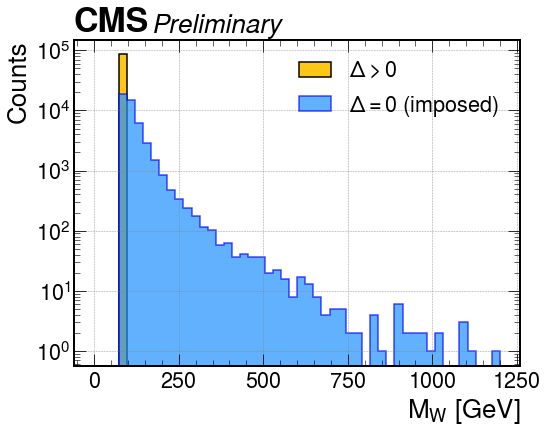

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(Wmass_good_low, bins=50, alpha=1, label="$\Delta>0$",
         range=(0, 1200), color=mcolors.XKCD_COLORS["xkcd:golden yellow"], histtype="stepfilled", linewidth=1.5, edgecolor="black")
plt.hist(Wmass_bad, bins=50, alpha=0.7, label=r"$\Delta=0$ (imposed)",
         range=(0, 1200), color="dodgerblue", edgecolor='blue', histtype="stepfilled", linewidth=1.5)
#plt.hist(Wmass_bad, bins=75, alpha=0.45,label=r"$\Delta=0 $ (imposed)", range=(0, 2300), color="fuchsia", edgecolor='violet', histtype="stepfilled", linewidth=1.5)
plt.legend()
plt.xlabel(r"$M_W$ [GeV]")
plt.ylabel("Counts")
hep.cms.text("Preliminary")
plt.yscale("log")
plt.grid(color="grey", linestyle="--", linewidth=0.5)


- Costruisci funzione che ritorna un branch maskato
- Ricostruisci pz neutrino eventi lhe e compara
- fai un plot con le 2 soluzioni a delta>0 e lhe
- fai un plot con soluzioni delta=0 e lhe
- fai relativi plot delle differenze dei pz tra ricostruiti e lhe

In [185]:
whereis_nu=signal.arrays("LHEPart_pdgId",library="ak")["LHEPart_pdgId"][:,[4,7]].to_numpy()
nu_eta_LHE=signal.arrays("LHEPart_eta",library="ak")["LHEPart_eta"][:,[4,7]].to_numpy()
nu_pt_LHE=signal.arrays("LHEPart_pt",library="ak")["LHEPart_pt"][:,[4,7]].to_numpy()
nu_mask=np.bitwise_or(whereis_nu==14,whereis_nu==-14)

In [186]:
nu_eta_LHE=nu_eta_LHE[nu_mask]
nu_pt_LHE=nu_pt_LHE[nu_mask]
nu_pz_LHE=nu_pt_LHE*np.sinh(nu_eta_LHE)

(array([4.7117e+04, 2.7643e+04, 1.6566e+04, 1.0725e+04, 7.3890e+03,
        5.2170e+03, 3.7770e+03, 2.8020e+03, 2.1260e+03, 1.6250e+03,
        1.3630e+03, 1.0420e+03, 8.4300e+02, 6.5800e+02, 5.6300e+02,
        4.4800e+02, 3.5100e+02, 2.9100e+02, 2.3000e+02, 2.0500e+02,
        1.8000e+02, 1.4800e+02, 1.1700e+02, 9.7000e+01, 9.0000e+01,
        7.1000e+01, 5.7000e+01, 6.3000e+01, 3.7000e+01, 3.8000e+01,
        3.9000e+01, 3.9000e+01, 2.6000e+01, 1.6000e+01, 1.1000e+01,
        1.3000e+01, 9.0000e+00, 7.0000e+00, 9.0000e+00, 8.0000e+00,
        5.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 5.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

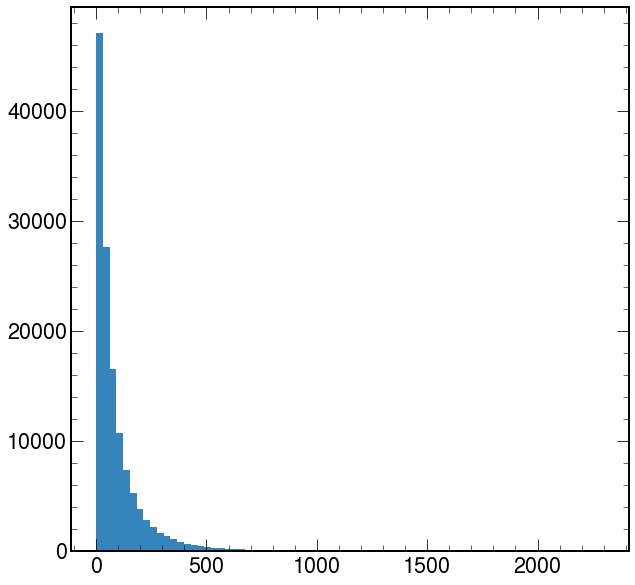

In [188]:
plt.hist(np.abs(nu_pz_LHE), bins=75, alpha=0.9,)